In [42]:
import sys
sys.path.append("../")

In [43]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot
import numpy as np

from infrastructure.quotehistory_collection import quotehistoryCollection as qc
from simulation.ema_cross_long_tp_sl_tester import EmaCrossLongTpSlTester

In [44]:
# Função para calcular o Kairi Relative Index (KRI)
def calculate_kri(close_prices, p_kri, kri_ema_s, kri_ema_l):
    # Calcula a média móvel simples (SMA)
    # sma = close_prices.rolling(window=period).mean()
    sma = close_prices.ewm(span=p_kri, min_periods=p_kri).mean()
    
    # Calcula o Kairi Relative Index (KRI)
    kri = ((close_prices - sma) / sma) * 100

    kri_ema_short = kri.ewm(span=kri_ema_s, min_periods=kri_ema_s).mean()
    kri_ema_long = kri.ewm(span=kri_ema_l, min_periods=kri_ema_l).mean()
    
    return kri, kri_ema_short, kri_ema_long
    
# Função para calcular a variação percentual acumulada em uma janela
def rolling_percent_change(close_prices, window):
    percent_changes = (close_prices.pct_change() * 100).rolling(window=window).sum()
    return percent_changes

# Função para calcular a EMA
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

# Função principal que calcula a variação percentual acumulada e as duas EMAs
def rolling_percent_change_with_two_emas(close_prices, window=14, ema_period_1=10, ema_period_2=60):
    # Calcula a variação percentual acumulada
    percent_change_buffer = rolling_percent_change(close_prices, window)

    # Calcula as duas EMAs
    ema1 = calculate_ema(percent_change_buffer, ema_period_1)
    ema2 = calculate_ema(percent_change_buffer, ema_period_2)

    return percent_change_buffer, ema1, ema2

In [54]:
BUY = 1
SELL = -1
NONE = 0

def apply_signal_long(row):
    if row.DELTA >= 0 and row.DELTA_PREV < 0:
        return BUY
    elif row.DELTA < 0 and row.DELTA_PREV >= 0:
        return SELL
    return NONE

def apply_signal_kri(row):
    if row.KRI < -1 and row.DELTA_KRI >= 0 and row.DELTA_PREV_KRI < 0:
        return BUY
    elif row.KRI > 1 and row.DELTA_KRI < 0 and row.DELTA_PREV_KRI >= 0:
        return SELL
    return NONE

In [55]:
def run_pair(pair,pip_value,use_spread=True,stop_loss = 1000, take_profit = 200, fixed_tp_sl=True):
    df_an = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")
    df_m5 = pd.read_pickle(f"../data/M5/{pair}_M5.pkl")
    df_an.reset_index(drop=True, inplace=True)
    df_m5.reset_index(drop=True, inplace=True)
    p_kri, kri_ema_s, kri_ema_l = 20,3,50
    df_an['KRI'], df_an[f'KRI_EMA_{kri_ema_s}'], df_an[f'KRI_EMA_{kri_ema_l}'] = calculate_kri(df_an['mid_c'], p_kri, kri_ema_s, kri_ema_l)
    # df_an['DELTA_KRI'] = df_an[f'KRI_EMA_{kri_ema_s}'] - df_an[f'KRI_EMA_{kri_ema_l}']
    df_an['DELTA_KRI'] = df_an[f'KRI'] - df_an[f'KRI_EMA_{kri_ema_s}']
    df_an['DELTA_PREV_KRI'] = df_an.DELTA_KRI.shift(1)
    ema_1 = 10
    ema_2 = 30
    df_an[f'EMA_{ema_1}'] = df_an.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
    df_an[f'EMA_{ema_2}'] = df_an.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()
    df_an['donchian_high'] = df_an['mid_c'].rolling(window=20).max()
    df_an['donchian_low'] = df_an['mid_c'].rolling(window=20).min()
    df_an['DELTA'] = df_an[f'EMA_{ema_1}'] - df_an[f'EMA_{ema_2}']
    df_an['DELTA_PREV'] = df_an.DELTA.shift(1)
    df_slim = df_an.copy()
    df_slim.dropna(inplace=True)
    
    df_slim.reset_index(drop=True, inplace=True)
    gt = EmaCrossLongTpSlTester(
        df_slim,
        apply_signal_kri,
        pip_value,
        df_m5,
        use_spread=use_spread,
        LOSS_FACTOR = stop_loss,
        PROFIT_FACTOR = take_profit,
        fixed_tp_sl=fixed_tp_sl
    )
    
    gt.run_test()
    return gt.df_results

In [56]:
pairs_pip_size = {
    "EURUSD": 0.0001,
    "GBPUSD": 0.0001,
    "USDJPY": 0.01,
    "USDCHF": 0.0001,
    "AUDUSD": 0.0001,
    "USDCAD": 0.0001,
    "NZDUSD": 0.0001,
    "EURGBP": 0.0001,
    "EURJPY": 0.01,
    "GBPJPY": 0.01,
    "XAUUSD": 0.01,   # Ouro
    # "XAGUSD": 0.01,  # Prata
    "BTCUSD": 0.01,   # Bitcoin com USD
    "ETHUSD": 0.01,   # Ethereum com USD
    # "XRPUSD": 0.0001, # Ripple com USD
    # "LTCUSD": 0.01,   # Litecoin com USD
    # "BCHUSD": 0.01,   # Bitcoin Cash com USD
    "BTCEUR": 0.01,   # Bitcoin com EUR
    "ETHEUR": 0.01,   # Ethereum com EUR
    # "XRPEUR": 0.0001, # Ripple com EUR
    # "LTCEUR": 0.01,   # Litecoin com EUR
}


pairs_pip_size = {
    "XAUUSD": 0.01,
}

In [60]:
qc.LoadQuotehistory("../data")

SL = [100,200,300,500,1000]
TP = [100,200,300,500,1000]

# SL = [1000]
# TP = [100]

res = []
for pair in pairs_pip_size:
    if pair in qc.quotehistory_dict.keys():
        print("\n\n")
        print(f" Pair ---------> {pair}")
        pip_size = pairs_pip_size[pair]
        for sl in SL:
            for tp in TP:
                print("\n")
                print(f"SL => {sl} | TP => {tp}")
                res.append(
                    dict(
                        pair=pair,
                        stop_loss=sl,
                        take_profit=tp,
                        res=run_pair(
                            pair,
                            pip_size,
                            use_spread=True,
                            stop_loss=sl,
                            take_profit=tp,
                            fixed_tp_sl=True
                        )
                    )
                )
                




 Pair ---------> XAUUSD


SL => 100 | TP => 100
prepare_data...
run_test...
Result: -10400.0


SL => 100 | TP => 200
prepare_data...
run_test...
Result: -8900.0


SL => 100 | TP => 300
prepare_data...
run_test...
Result: -9400.0


SL => 100 | TP => 500
prepare_data...
run_test...
Result: -15200.0


SL => 100 | TP => 1000
prepare_data...
run_test...
Result: -14900.0


SL => 200 | TP => 100
prepare_data...
run_test...
Result: -23200.0


SL => 200 | TP => 200
prepare_data...
run_test...
Result: -22400.0


SL => 200 | TP => 300
prepare_data...
run_test...
Result: -23900.0


SL => 200 | TP => 500
prepare_data...
run_test...
Result: -31500.0


SL => 200 | TP => 1000
prepare_data...
run_test...
Result: -32800.0


SL => 300 | TP => 100
prepare_data...
run_test...
Result: -30200.0


SL => 300 | TP => 200
prepare_data...
run_test...
Result: -27600.0


SL => 300 | TP => 300
prepare_data...
run_test...
Result: -30000.0


SL => 300 | TP => 500
prepare_data...
run_test...
Result: -39400.0


SL =>

In [61]:
for r in res:
    print(r['pair'], r['res'].result.sum())

XAUUSD -10400.0
XAUUSD -8900.0
XAUUSD -9400.0
XAUUSD -15200.0
XAUUSD -14900.0
XAUUSD -23200.0
XAUUSD -22400.0
XAUUSD -23900.0
XAUUSD -31500.0
XAUUSD -32800.0
XAUUSD -30200.0
XAUUSD -27600.0
XAUUSD -30000.0
XAUUSD -39400.0
XAUUSD -41600.0
XAUUSD -38200.0
XAUUSD -33600.0
XAUUSD -35000.0
XAUUSD -46000.0
XAUUSD -44500.0
XAUUSD -31300.0
XAUUSD -28400.0
XAUUSD -29900.0
XAUUSD -45500.0
XAUUSD -45000.0


In [59]:
df_results = res[0]['res']
pair = res[0]['pair']
print(pair)
df_results.shape, df_results[df_results['result'] > 0].shape, df_results[df_results['result'] < 0].shape

XAUUSD


((182, 14), (137, 14), (45, 14))

In [51]:
df_results.result.sum()

np.float64(-8800.0)

In [52]:
sum_neg = df_results[df_results['result'] < 0].result.sum()
sum_neg, sum_neg/df_results[df_results['result'] < 0].shape[0]

(np.float64(-10000.0), np.float64(-1000.0))

In [53]:
df_results.sort_values(by='start_time', inplace=True)
df_results.head(50)

,running,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time
0,False,56166,100,1000,0.01,1000.0,1432.20,1430.52,-1,1431.14,1442.14,100.0,2019-06-25 05:20:00,2019-06-25 05:00:00
1,False,93758,100,1000,0.01,1000.0,1574.30,1572.83,-1,1573.10,1584.10,100.0,2020-01-06 07:20:00,2020-01-06 05:00:00
2,False,103395,100,1000,0.01,1000.0,1677.55,1687.75,-1,1676.55,1687.55,-1000.0,2020-02-24 13:00:00,2020-02-24 13:00:00
3,False,107162,100,1000,0.01,1000.0,1579.04,1551.08,1,1580.04,1569.04,-1000.0,2020-03-13 05:00:00,2020-03-13 05:00:00
4,False,107390,100,1000,0.01,1000.0,1547.79,1571.90,1,1548.79,1537.79,100.0,2020-03-16 01:00:00,2020-03-16 01:00:00
5,False,107582,100,1000,0.01,1000.0,1508.58,1464.30,1,1509.58,1498.58,-1000.0,2020-03-16 17:00:00,2020-03-16 17:00:00
6,False,107810,100,1000,0.01,1000.0,1484.65,1469.79,1,1485.65,1474.65,-1000.0,2020-03-17 13:00:00,2020-03-17 13:00:00
7,False,108218,100,1000,0.01,1000.0,1484.77,1487.54,1,1485.77,1474.77,100.0,2020-03-19 01:00:00,2020-03-19 01:00:00
8,False,109286,100,1000,0.01,1000.0,1607.43,1625.24,-1,1606.43,1617.43,-1000.0,2020-03-24 21:00:00,2020-03-24 21:00:00
9,False,109515,100,1000,0.01,1000.0,1605.30,1603.20,-1,1604.30,1615.30,100.0,2020-03-25 18:35:00,2020-03-25 17:00:00


In [36]:

def get_mas(df, MA_LIST):
    for ma in MA_LIST:
        df[f"EMA_{ma}"] = df.mid_c.ewm(span=ma, min_periods=ma).mean()
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

df_4h = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")
df_4h = get_mas(df_4h, [10,20,30,50, 100])
p_kri, kri_ema_s, kri_ema_l = 20,3,50
df_4h[f'KRI_{p_kri}'], df_4h[f'KRI_EMA_{kri_ema_s}'], df_4h[f'KRI_EMA_{kri_ema_l}'] = calculate_kri(df_4h['mid_c'], p_kri, kri_ema_s, kri_ema_l)
window = 20
ema_1 = 50
ema_2 = 100
df_4h['donchian_high'] = df_4h['mid_c'].rolling(window=window).max()
df_4h['donchian_low'] = df_4h['mid_c'].rolling(window=window).min()
df_4h['DELTA'] = df_4h[f'EMA_{ema_1}'] - df_4h[f'EMA_{ema_2}']
df_4h['DELTA_PREV'] = df_4h.DELTA.shift(1)
df_4h["SIGNAL"] = df_4h.apply(apply_signal_long, axis=1)
df_4h.dropna(inplace=True)
df_4h.reset_index(drop=True,inplace=True)

df_5m = pd.read_pickle(f"../data/M5/{pair}_M5.pkl")
window = 300
df_5m['donchian_high'] = df_5m['mid_c'].rolling(window=window).max()
df_5m['donchian_low'] = df_5m['mid_c'].rolling(window=window).min()
df_5m = get_mas(df_5m, [100, 300])

In [37]:
df_4h.head()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,...,EMA_50,EMA_100,KRI_20,KRI_EMA_3,KRI_EMA_50,donchian_high,donchian_low,DELTA,DELTA_PREV,SIGNAL
0,2018-02-08 20:00:00,1319.79,1320.35,1315.71,1318.28,1319.79,1320.35,1315.71,1318.28,1319.79,...,1331.666809,1334.370795,-0.416636,-0.529325,-0.481273,1343.31,1310.23,-2.703986,-2.493907,0
1,2018-02-09 00:00:00,1318.21,1322.56,1318.02,1319.29,1318.21,1322.56,1318.02,1319.29,1318.21,...,1331.180881,1334.061640,-0.307997,-0.418661,-0.473463,1343.31,1310.23,-2.880760,-2.703986,0
2,2018-02-09 04:00:00,1319.28,1319.59,1316.05,1317.82,1319.28,1319.59,1316.05,1317.82,1319.28,...,1330.656341,1333.728921,-0.379284,-0.398973,-0.469242,1343.31,1310.23,-3.072580,-2.880760,0
3,2018-02-09 08:00:00,1317.67,1320.47,1313.52,1316.09,1317.67,1320.47,1313.52,1316.09,1317.67,...,1330.084501,1333.367824,-0.461675,-0.430324,-0.468905,1343.31,1310.23,-3.283324,-3.072580,0
4,2018-02-09 12:00:00,1316.01,1318.01,1313.53,1315.84,1316.01,1318.01,1313.53,1315.84,1316.01,...,1329.525318,1333.009242,-0.434981,-0.432652,-0.467402,1343.07,1310.23,-3.483924,-3.283324,0


In [38]:
df_5m.head()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,mid_h,mid_l,mid_c,donchian_high,donchian_low,EMA_100,EMA_300
0,2018-01-18 15:00:00,1328.54,1330.14,1326.84,1329.98,1328.54,1330.14,1326.84,1329.98,1328.54,1330.14,1326.84,1329.98,1343.69,1305.92,1331.980759,1327.401212
1,2018-01-18 16:00:00,1330.06,1332.39,1328.73,1330.80,1330.06,1332.39,1328.73,1330.80,1330.06,1332.39,1328.73,1330.80,1343.69,1305.92,1331.957321,1327.427303
2,2018-01-18 17:00:00,1330.80,1331.84,1328.58,1329.59,1330.80,1331.84,1328.58,1329.59,1330.80,1331.84,1328.58,1329.59,1343.69,1305.92,1331.910331,1327.443888
3,2018-01-18 18:00:00,1329.61,1333.06,1328.90,1329.73,1329.61,1333.06,1328.90,1329.73,1329.61,1333.06,1328.90,1329.73,1343.69,1305.92,1331.867056,1327.461401
4,2018-01-18 19:00:00,1329.75,1331.45,1328.70,1329.04,1329.75,1331.45,1328.70,1329.04,1329.75,1331.45,1328.70,1329.04,1343.69,1306.37,1331.810946,1327.473482


In [39]:
# cp = CandlePlot(df_4h.iloc[0:500])
# cp.show_plot(line_traces=['EMA_10','EMA_30','donchian_high','donchian_low'])

In [40]:
# cp = CandlePlot(df_5m.iloc[500:3000])
# cp.show_plot(line_traces=['EMA_100','EMA_300','donchian_high','donchian_low'])

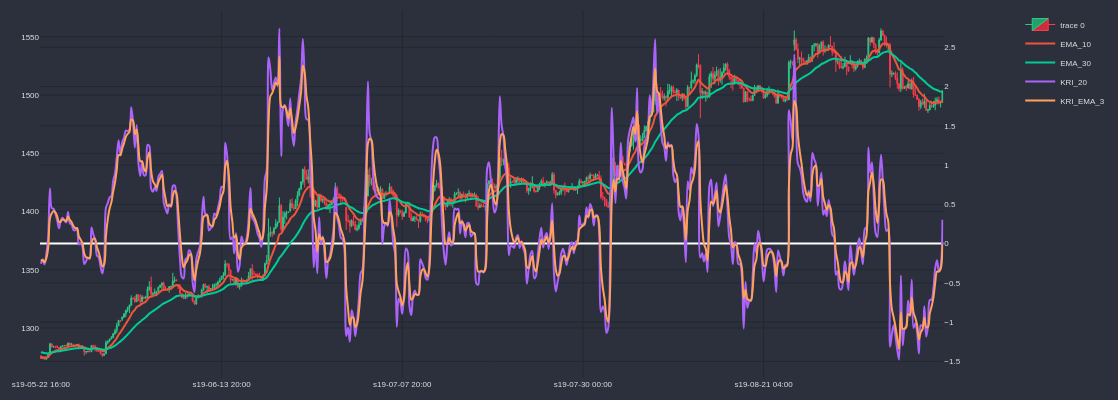

In [41]:

cp = CandlePlot(df_4h.iloc[2000:2500])
cp.show_plot(line_traces=['EMA_10', 'EMA_30'],sec_traces=['KRI_20', 'KRI_EMA_3'])


